# **Q-means** | Quantum K-means


## Introdução

A técnica de clustering, em machine learning, é um processo de agrupamento de dados semelhantes com base em suas características e propriedades compartilhadas. Ela desempenha um papel fundamental na análise de dados e na descoberta de estruturas ocultas em conjuntos de dados, permitindo a organização e a compreensão dos dados de maneira mais eficaz. O clustering é amplamente utilizado em diversas aplicações, desde a segmentação de clientes em marketing até a classificação de documentos na mineração de textos.

Um dos algoritmos clássicos de clustering é o k-means, que busca dividir os dados em k grupos, minimizando a variância intra-grupo. No entanto, à medida que lidamos com conjuntos de dados cada vez maiores e mais complexos, a computação clássica pode se tornar ineficiente na execução desses algoritmos.

Nesse contexto, os algoritmos quânticos, como o q-means, têm o potencial de revolucionar o campo do clustering. O q-means é uma versão quântica do k-means que aproveita os princípios da mecânica quântica para processar informações de maneira paralela e mais eficiente. Em vez de lidar com bits clássicos, que podem representar 0 ou 1, os computadores quânticos usam qubits, que podem representar 0, 1 ou qualquer superposição desses estados, o que permite uma abordagem de busca mais eficaz.

O algoritmo q-means pode acelerar significativamente o processo de clustering em grandes conjuntos de dados, pois explora todas as possíveis combinações de agrupamento de maneira simultânea. Isso é particularmente valioso em cenários onde a quantidade de dados é vasta e a análise tradicional seria computacionalmente proibitiva.

Com este notebook, vamos implementar e explicar detalhadamente o funcionamento desse algoritmo. Além disso, vamos avaliá-lo utilizando alguns datasets clássicos.

## 1. Setup

Vamos primeiro importar algumas bibliotecas que serão utilizadas no desenvolvimento desse projeto.

O código importa bibliotecas e módulos comumente usados para análise de dados, visualização e tarefas de aprendizado de máquina.
- numpy (como np) é usado para operações numéricas.
- matplotlib.pyplot (como plt) é usado para visualização de dados.
- math fornece funções matemáticas e constantes.
- pandas (como pd) é usado para manipulação e análise de dados.
- time é usado para medir o tempo de execução de partes específicas do código.

Também importamos módulos específicos do scikit-learn (sklearn), uma biblioteca popular de aprendizado de máquina em Python.
- `load_iris`, `load_wine` e `load_breast_cancer` são funções para carregar conjuntos de dados de exemplo do `scikit-learn`.
- `PCA` é usado para análise de componentes principais, uma técnica de redução de dimensionalidade.
- `MinMaxScaler` é usado para dimensionar recursos para o intervalo de 0 a 1.
- `davies_bouldin_score` e `silhouette_score` são usados para métricas de avaliação de clusters.


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score

Agora, a biblioteca `qiskit` é importada, que é uma biblioteca popular de computação quântica em Python.
- `Aer` fornece acesso aos backends de simulação para circuitos quânticos.
- `IBMQ` é usado para se conectar ao IBM Quantum Experience e acessar dispositivos quânticos reais.
- `execute` é usado para executar circuitos quânticos em um backend escolhido.
- `QuantumCircuit` é usado para criar circuitos quânticos.
- `ClassicalRegister` e 'QuantumRegister' são usados para criar registros clássicos e quânticos, respectivamente.

`Aer.get_backend` é usado para selecionar o backend `qasm_simulator` para a simulação.
O backend `qasm_simulator` é um simulador local que permite simular circuitos quânticos sem usar um dispositivo quântico real.


In [3]:
from math import pi
from qiskit import Aer, IBMQ, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

backend = Aer.get_backend('qasm_simulator')

## 2. Funções úteis

Nesse bloco de código, vamos implementar algumas funções úteis que vão guiar nossa implementação do algortimo.

Primeiro, vamos definir uma função chamada ``get_theta`` que recebe uma tupla `d` como entrada. Dentro da função, a tupla 'd' é descompactada em duas variáveis, `x` e `y`. Em seguida, a função calcula o valor de `theta` usando a fórmula ``(x + 1) * (π/2)`` e o valor de `phi` usando a fórmula ``(y + 1) * (π/2)``, onde 'π' é a constante matemática Pi. Por fim, a função retorna uma tupla contendo esses dois valores calculados, `theta` e `phi`.

![Bloch sphere](bloch.png)

#### Referência: [Phase and Angle Variables in Quantum Mechanics, 1968, Laboratory of Nuclear Studies](https://astro.swarthmore.edu/comps/phase.pdf)

In [4]:
def get_theta(d):
    x, y = d[0], d[1]

    theta = (x + 1) * (pi / 2)
    phi = (y + 1) * (pi / 2)

    return theta, phi

Agora, vamos definir uma função chamada `get_distance` com 2 parâmetros de entrada: `x`, `y`. Dentro da função, ela calcula os valores de `theta` e `phi` para `x` e `y` chamando a função `get_theta`. Em seguida, cria um circuito quântico envolvendo um registro quântico e um registro clássico, aplicando uma série de portas quânticas, incluindo as portas Hadamard, Rz, Ry e u3 em qubits específicos. O circuito é projetado para calcular uma medida de distância quântica entre dois estados quânticos representados por `x` e `y`. O resultado é armazenado no registro clássico. Posteriormente, o circuito é executado em um simulador quântico com 2048 execuções (shots), e a função retorna a probabilidade de obter o resultado `001` como a medida de distância.

$|0_{anc}\rangle$ é o qubit auxiliar, através da porta $H$, mudará para $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$. Então sob o controle de $|1\rangle$, o circuito vai fazer o swap dos vetores $|x\rangle$ e $|y\rangle$. Finalmente, o resultado no lado direito do circuito:

$$|0_{anc}\rangle |x\rangle |y\rangle \rightarrow \frac{1}{2}|0_{anc}\rangle(|xy\rangle + |yx\rangle) + \frac{1}{2}|1_{anc}\rangle(|xy\rangle - |yx\rangle)$$

Se medirmos o qubit auxiliar isolado, a probabilidade no estado final é $|001\rangle$:

$$P(|001_{anc}\rangle) = \frac{1}{2} - \frac{1}{2}|\langle x | y \rangle|^2$$

Essa equação tem uma ``correlação positiva`` com a equação de distância euclidiana quântica que pode ser representada pela seguinte equação:

$$Euclidean \ distance = \sqrt{(2 - 2|\langle x | y \rangle|)}$$

![Distance Circuit](d_circuit.png)

#### Referência: [Calculate Quantum Euclidean Distance with Qiskit, 2022](https://medium.com/qiskit/calculate-quantum-euclidean-distance-with-qiskit-df85525ab485)

In [5]:
def get_distance(x, y, shots=2048):
    theta_1, phi_1 = get_theta(x)
    theta_2, phi_2 = get_theta(y)
    
    qr = QuantumRegister(3, name='qr')
    cr = ClassicalRegister(3, name='cr')
    qc = QuantumCircuit(qr, cr, name='k_means')
    
    qc.h(qr[0])
    
    qc.rz(theta_1, qr[1])
    qc.ry(theta_1, qr[1])
    qc.u(theta_1, phi_1, 0, qr[1]).inverse
    qc.rz(theta_2, qr[2])
    qc.ry(theta_2, qr[2])
    qc.u(theta_2, phi_2, 0, qr[2]).inverse
    
    qc.cswap(qr[0], qr[1], qr[2])

    qc.h(qr[0])
        
    qc.measure(qr[0], cr[0])
        
    job = execute(qc, backend=backend, shots=shots)
    result = job.result()
    data = result.get_counts(qc)
    
    if len(data) == 1:
        return 0.0
    else:
        return data['001'] / shots

Também vamos definir uma função chamada `get_data`. A função determina qual conjunto de dados carregar com base no valor do parâmetro `model`. Se `model` for `iris`, o conjunto de dados Iris é carregado; se `model` for `wine`, o conjunto de dados Wine é carregado; caso contrário, o conjunto de `breast cancer` é carregado por padrão. Em seguida, os dados carregados são transformados em um DataFrame `df` usando as características e nomes de recursos fornecidos no conjunto de dados. Posteriormente, é realizada uma Análise de Componentes Principais (PCA) com 2 componentes. Os dados são transformados em pontos bidimensionais usando o PCA, e esses pontos transformados são retornados como resultado da função. Em resumo, essa função carrega um dos três conjuntos de dados com base no valor do parâmetro `model`, aplica PCA para reduzir a dimensionalidade dos dados para 2 componentes e retorna os pontos transformados.

In [6]:
def get_data(model):
    if model == 'iris':
        data1 = load_iris()
    elif model == 'wine':
        data1 = load_wine()
    else:
        data1 = load_breast_cancer()

    df = pd.DataFrame(data1['data'], columns=data1['feature_names'])

    pca_1 = PCA(n_components=2)
    pca_1.fit(df)

    points = pca_1.transform(df)

    return points

Buscando visualizar melhor nossos resultados, vamos definir uma função chamada `draw_plot` com três parâmetros de entrada: points, centers e label (rótulo). A função desenha um gráfico de dispersão (`scatter plot`) com base no valor do parâmetro `label`. Se `label` for falso, a função simplesmente traça os pontos no gráfico de dispersão sem considerar os centros. Se `label` for verdadeiro, a função atribui cores diferentes aos pontos de acordo com os centros a que pertencem e exibe uma legenda indicando os clusters. Além disso, a função define limites para os eixos x e y do gráfico e, por fim, exibe o gráfico de dispersão

In [7]:
def draw_plot(points, centers, label=True):
    if label == False:
        plt.scatter(points[:, 0], points[:, 1], s=3)
        
    else:
        for cluster_id in np.unique(centers):
            cluster_data = points[centers == cluster_id]
            plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {int(cluster_id) + 1}', s=3)
        plt.legend(loc='lower right', fontsize=6)

    plt.xlim(-0.15, 1.2)
    plt.ylim(-0.15, 1.2)
    
    plt.show()

Vamos agora implementar uma função chamada `plot_centroids` com um parâmetro de entrada: centers (centros). A função é responsável por criar um gráfico de dispersão que mostra os centroids (pontos centrais) de clusters. Ela usa as coordenadas ``x`` da primeira coluna ``(centers[:, 0])`` e as coordenadas y da segunda coluna ``(centers[:, 1])`` do array `centers` para plotar os pontos. O parâmetro `s=3` define o tamanho dos pontos no gráfico como 3. Além disso, a função ajusta automaticamente os limites dos eixos x e y do gráfico para garantir que todos os centroids sejam visíveis. Por fim, exibe o gráfico com os centroids.

In [8]:
def plot_centroids(centers):
    plt.scatter(centers[:, 0], centers[:, 1], s=3)
    
    plt.xlim(-0.15, 1.2)
    plt.ylim(-0.15, 1.2)
    
    plt.show()

Agora vamos tratar da inicialização: para isso, vamos definir a função `initialize_centers` com dois parâmetros de entrada: `points` (pontos) e `k` (número de centros desejados). O código utiliza a função random.randint do NumPy para selecionar aleatoriamente `k` índices de pontos (índices de linhas) do array `points`. Os inteiros aleatórios estarão no intervalo ``[0, points.shape[0])``, onde ``points.shape[0]`` representa o número de linhas no array 'points'. Isso significa que os índices estarão no intervalo ``[0, points.shape[0]-1]``. A função retorna os `k` pontos iniciais escolhidos aleatoriamente do array `points` como os centros iniciais para um algoritmo de clusterização.

In [9]:
def initialize_centers(points, k):
    np.random.seed(45)
    
    return points[np.random.randint(points.shape[0], size=k), :]

Uma das etapas fundamentais em um algoritmo de clusterização é encontrar o vizinho mais próximo. Portanto, agora temos a função `find_nearest_neighbour` com três parâmetros de entrada: `points` (pontos de dados), `centroids` (centroides). A função calcula o centro mais próximo para cada ponto de dados em relação aos centroides.

In [10]:
def find_nearest_neighbour(points, centroids):
    n = len(points)
    k = centroids.shape[0]
    
    centers = np.zeros(n)
    
    for i in range(n):
        min_dis = 10000
        index = 0
        
        for j in range(k):
            temp_dist = get_distance(points[i, :], centroids[j, :])
            
            if temp_dist < min_dis:
                min_dis = temp_dist
                index = j
        
        centers[i] = index
    
    return centers

Vamos agora implementar a função `find_centroids` com dois parâmetros de entrada: `points` (pontos de dados) e `centers` (índices de clusters). A função calcula os centroides (pontos centrais) para os clusters representados pelos índices em `centers`.

Primeiramente, a função obtém o número de pontos de dados (n) e o número de clusters (k) observando o valor máximo em `centers` e adicionando 1. Em seguida, ela cria um array `centroids` de zeros com dimensões (k, 2), onde cada linha representa as coordenadas x e y de um centro.

A função itera por cada cluster (índices de 0 a k-1) e calcula a média (média) das coordenadas dos pontos de dados pertencentes ao cluster atual usando a função `np.average()`. O resultado da média é atribuído às coordenadas do centro correspondente na matriz `centroids`. Por fim, a função retorna os centroides calculados, que representam os pontos centrais de cada cluster.

Essa função desempenha um papel fundamental na atualização dos centroides durante o processo de clusterização, garantindo que eles representem corretamente os pontos centrais de cada cluster.

In [11]:
def find_centroids(points, centers):
    k = int(np.max(centers)) + 1
    
    centroids = np.zeros([k, 2])
    
    for i in range(k):
        centroids[i, :] = np.average(points[centers == i], axis=0)
    
    return centroids

Vamos criar uma breve função com o objetivo de pré-processar os dados, especificamente normalizando-os para o intervalo ``[0, 1]``. Primeiramente, criamos uma instância do ``MinMaxScaler``, que é um objeto responsável pela escala dos dados. Em seguida, utilizamos o método `fit_transform` do ``MinMaxScaler`` para realizar a normalização dos pontos de dados. Esse método calcula os valores mínimos e máximos de cada característica nos pontos de dados e dimensiona os pontos para que fiquem dentro do intervalo desejado, neste caso, ``[0, 1]``. O resultado é a matriz `normalized_data` contendo os pontos de dados normalizados, que é retornada pela função. Esse tipo de pré-processamento é frequentemente utilizado para garantir que os dados estejam em uma escala uniforme antes de aplicar algoritmos de aprendizado de máquina.

In [12]:
def preprocess(points):
    scaler = MinMaxScaler()
    
    normalized_data = scaler.fit_transform(points)
    
    return normalized_data

## 3. Experimentos

Agora, vamos executar e avaliar nosso algoritmo. Para isso, vamos definir um pipeline composto por algumas etapas que vai nos ajudar a executar essa tarefa.

1. Define o número de centros (k), o modelo de conjunto de dados (`iris` neste caso).

2. Obtém os pontos de dados usando o modelo especificado (`iris`) por meio da função `get_data(model)`.

3. Pré-processa (normalizar) os pontos de dados usando a escala Min-Max por meio da função `preprocess(points)`.

4. Inicializa os centróides para o algoritmo k-means usando a função `initialize_centers(points, k)`.

5. Plota os pontos de dados iniciais sem os centróides ``(label=False)`` para visualização.

6. Executa o algoritmo k-means por um número fixo de iterações (100 neste caso) em um loop:

    * Encontra os centróides mais próximos para cada ponto de dados usando os centróides atuais por meio da função 'find_nearest_neighbour(points, centroids, count1)'.
    * Atualiza os centróides com base na média dos pontos de dados pertencentes a cada cluster por meio da função 'find_centroids(points, centers)'.
    * Incrementa a variável count1.

7. Plota os pontos de dados com os centróides após a última iteração para visualização.

8. Calcula o Índice de Davies-Bouldin para avaliar a qualidade do agrupamento (``clustering quality``) usando a função `davies_bouldin_score(points, centers)` e imprime o resultado.

9. Calcula o Silhouette Score para avaliar a qualidade do agrupamento (clustering quality) usando a função `silhouette_score(points, centers)` e imprime o resultado.

10. Calcula o tempo de execução do algoritmo k-means e imprime o resultado.

In [13]:
def perform_clustering(model, k):
    points = get_data(model)
    points = preprocess(points)
    centroids = initialize_centers(points, k)

    plt.figure()
    draw_plot(points, centroids, label=False)

    start_time = time.time()
    for i in range(100):
        centers = find_nearest_neighbour(points, centroids)
        centroids = find_centroids(points, centers)
    end_time = time.time()

    plt.figure()
    draw_plot(points, centers)

    db_index = davies_bouldin_score(points, centers)
    print('Davies-Bouldin Index:', db_index)

    score = silhouette_score(points, centers)
    print('Silhouette Score:', score)

    exec_time = end_time - start_time
    print('Execution time: ', exec_time)

## 3.1 Dataset Iris

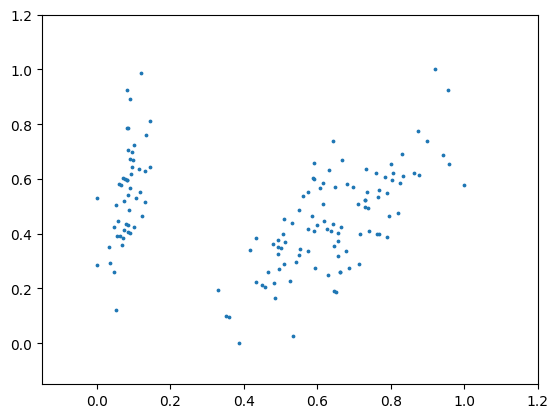

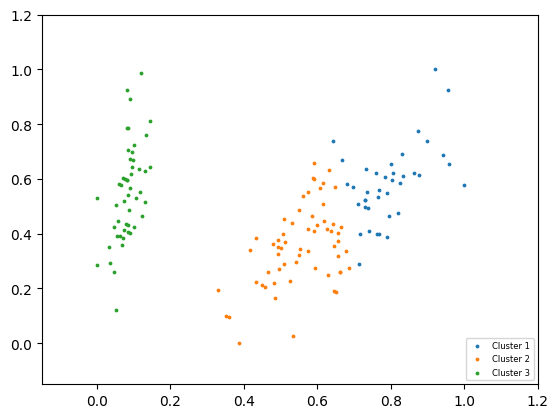

Davies-Bouldin Index: 0.751271599544573
Silhouette Score: 0.4769213194622264
Execution time:  555.079699754715


In [14]:
perform_clustering('iris', k=3)

## 3.2 Dataset Wine

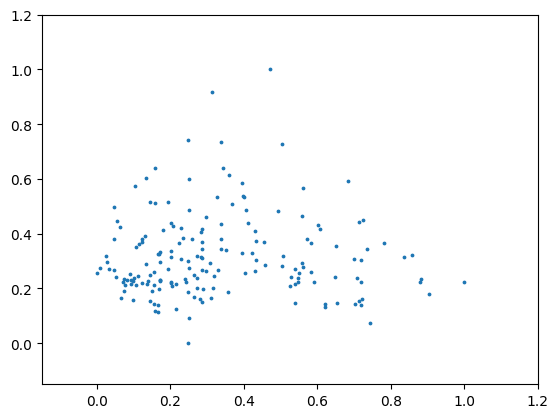

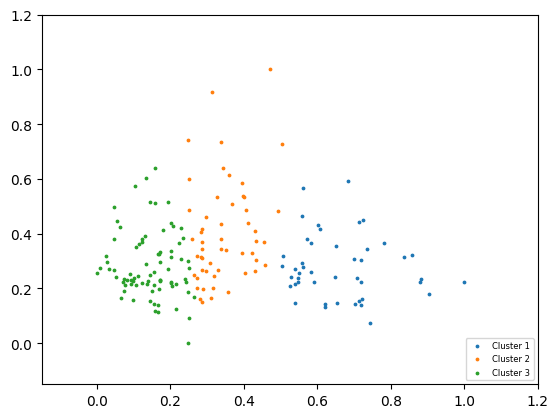

Davies-Bouldin Index: 1.1245530499106053
Silhouette Score: 0.35222053197063224
Execution time:  700.7572836875916


In [15]:
perform_clustering('wine', k=3)

## 3.3 Dataset Breast Cancer

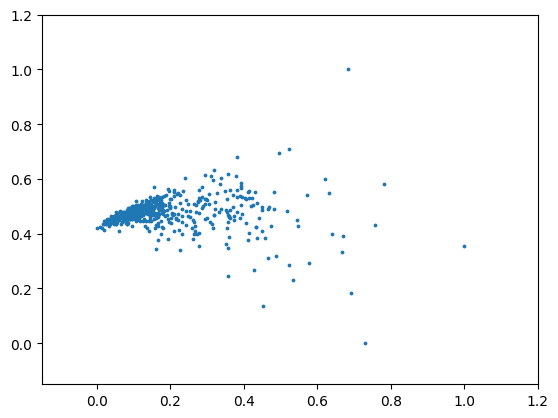

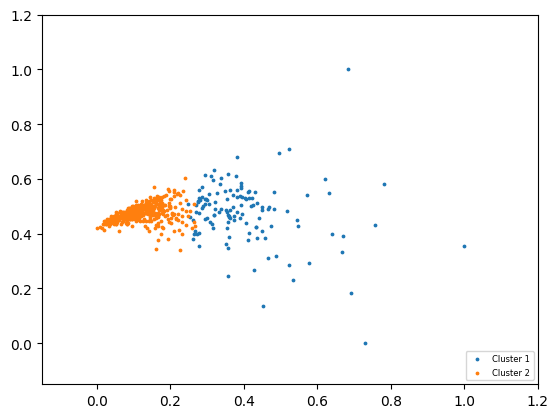

Davies-Bouldin Index: 0.6543544766588894
Silhouette Score: 0.6462235409830239
Execution time:  1514.8030350208282


In [16]:
perform_clustering('bc', k=2)

## 4. Conclusões

Os resultados obtidos para o algoritmo q-means em três datasets diferentes (WINE, IRIS e BREAST CANCER) apresentam algumas diferenças notáveis:

**Davies-Bouldin Index (DBI):**

No dataset IRIS, o DBI é de aproximadamente 0.7512.
No dataset WINE, o DBI é de aproximadamente 1.1245.
No dataset BREAST CANCER, o DBI é de aproximadamente 0.654354.
> Análise: O DBI é uma métrica que avalia a compactação e a separação entre clusters. Valores menores indicam clusters mais compactos e bem separados. Portanto, o menor valor foi obtido no dataset BREAST CANCER, sugerindo uma melhor qualidade do agrupamento em comparação com os outros datasets.

**Silhouette Score:**

No dataset IRIS, o Silhouette Score é de aproximadamente 0.4769.
No dataset WINE, o Silhouette Score é de aproximadamente 0.3522.
No dataset BREAST CANCER, o Silhouette Score é de aproximadamente 0.6462.
> Análise: O Silhouette Score mede o quão bem os clusters estão separados e quão semelhantes os pontos estão dentro dos clusters. Valores mais próximos de 1 indicam clusters bem definidos. Nesse caso, o dataset BREAST CANCER tem o melhor resultado, sugerindo uma melhor separação e consistência dos clusters.

**Tempo de Execução:**

No dataset IRIS, o tempo de execução é de aproximadamente 555.0796 segundos.
No dataset WINE, o tempo de execução é de aproximadamente 700.7572 segundos.
No dataset BREAST CANCER, o tempo de execução é de aproximadamente 1514.8030 segundos.
> Análise: O tempo de execução é significativamente maior no dataset BREAST CANCER, seguido pelo dataset WINE. Isso pode ser devido à complexidade do algoritmo ou à quantidade de dados. O dataset IRIS possui o menor tempo de execução.

Em resumo, o dataset BREAST CANCER obteve os melhores resultados em ambas as métricas de avaliação, sugerindo que o algoritmo ``q-means`` funcionou melhor na tarefa de clusterização nesse conjunto de dados. No entanto, é importante notar que o tempo de execução no dataset BREAST CANCER é substancialmente maior. Portanto, a escolha do dataset a ser usado deve considerar um equilíbrio entre a qualidade do agrupamento e o tempo de execução, dependendo dos requisitos da aplicação. O dataset IRIS também apresentou bons resultados em ambas as métricas, sendo uma escolha intermediária em termos de desempenho e qualidade de clustering. Por fim, o dataset WINE obteve os resultados menos favoráveis, com pontuações mais baixas em ambas as métricas e um tempo de execução intermediário.